In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

import pymc3 as pm
import theano
import theano.tensor as tt
import arviz as az

In [2]:
sns.set(font_scale=1.5)
np.random.seed(632020)

In [3]:
def plot_data(actions, rewards, Qs):
    plt.figure(figsize=(20,3))
    x = np.arange(len(actions))

    plt.plot(x, Qs[:, 0] - .5 + 0, c='C0', lw=3, alpha=.3)
    plt.plot(x, Qs[:, 1] - .5 + 1, c='C1', lw=3, alpha=.3)

    s = 50
    lw = 2

    cond = (actions == 0) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C0', lw=lw)

    cond = (actions == 0) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C0', ec='C0', lw=lw)

    cond = (actions == 1) & (rewards == 0)
    plt.scatter(x[cond], actions[cond], s=s, c='None', ec='C1', lw=lw)

    cond = (actions == 1) & (rewards == 1)
    plt.scatter(x[cond], actions[cond], s=s, c='C1', ec='C1', lw=lw)

    plt.scatter(0, 20, c='k', s=s, lw=lw, label='Reward')
    plt.scatter(0, 20, c='w', ec='k', s=s, lw=lw, label='No reward')
    plt.plot([0,1], [20, 20], c='k', lw=3, alpha=.3, label='Qvalue (centered)')


    plt.yticks([0,1], ['left', 'right'])
    plt.ylim(-1, 2)

    plt.ylabel('action')
    plt.xlabel('trial')

    handles, labels = plt.gca().get_legend_handles_labels()
    order = (1,2,0)
    handles = [handles[idx] for idx in order]
    labels = [labels[idx] for idx in order]

    plt.legend(handles, labels, fontsize=12, loc=(1.01, .27))
    plt.tight_layout()

In [6]:


def generate_data(alpha, beta, n=100, p_r=[.4, .6]):
    actions = np.zeros(n, dtype=int)
    rewards = np.zeros(n, dtype=int)
    Qs = np.zeros((n, 2))

    # Initialize Q table
    Q = np.array([.5, .5])
    for i in range(n):
        # Apply the Softmax transformation
        exp_Q = np.exp(beta*Q)
        prob_a = exp_Q / np.sum(exp_Q)

        # Simulate choice and reward
        a = np.random.choice([0, 1], p=prob_a)
        r = np.random.rand() < p_r[a]

        # Update Q table
        Q[a] = Q[a] + alpha * (r - Q[a])

        # Store values
        actions[i] = a
        rewards[i] = r
        Qs[i] = Q.copy()

    return actions, rewards, Qs

In [7]:
true_alpha = .5
true_beta = 5
n = 150
actions, rewards, Qs = generate_data(true_alpha, true_beta, n)

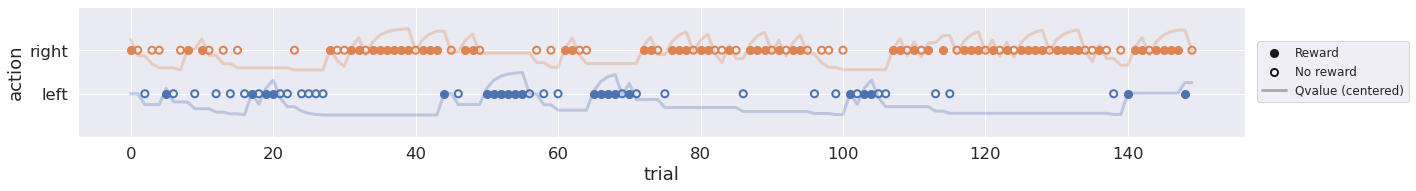

In [8]:
plot_data(actions, rewards, Qs)

In [12]:
actions2 = [3, 5, 4, 2, 7, 6, 6, 4, 1, 4, 5, 7, 8, 6, 5, 7, 9, 9, 4, 4, 3]

rewards2 = [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0]

In [14]:
def llik_td(x, *args):
    # Extract the arguments as they are passed by scipy.optimize.minimize
    alpha, beta = x
    actions, rewards = args

    # Initialize values
    Q = np.array([.5, .5])
    log_prob_actions = np.zeros(len(actions))

    for t, (a, r) in enumerate(zip(actions,rewards)):
        # Apply the softmax transformation
        Q_ = Q * beta
        log_prob_action = Q_ - scipy.special.logsumexp(Q_)

        # Store the log probability of the observed action
        log_prob_actions[t] = log_prob_action[a]

        # Update the Q values for the next trial
        Q[a] = Q[a] + alpha * (r - Q[a])

    # Return the negative log likelihood of all observed actions
    return -np.sum(log_prob_actions[1:])

In [21]:
actions3 = []
for i in actions2:
    actions3.append(i/max(actions2))

In [15]:
llik_td([true_alpha, true_beta], *(actions, rewards))

61.13409689119125

In [22]:
llik_td([true_alpha, true_beta], *(actions3, rewards2))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices